# Convolutional Neural Networks with PyTorch Exercise (5 points)



# 1. Load the Dataset

We will use the LFW dataset (Labeled Faces in the Wild), which as you may recall we used in Lecture 21, and consists of 5,000 images of 62 celebrities. The dataset is split into train, test, and validation datasets, saved as pickled files, and it can be downloaded by following this [link](https://www.dropbox.com/sh/1et0orsnzmubs1f/AAAfSJ10G2duian1bcpBDE6aa?dl=0). If you use Google Colab for this exercise, upload the folder `data` to Google Drive. 

Create a new dataset class for loading the LFW dataset, as a subclass of the PyTorch `Dataset` class, similar to the example in Lecture 17. 


In [1]:
# Your Code Here
from torch.utils.data import Dataset, DataLoader
import torch
import gzip
import pickle
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision.transforms import ToTensor

class MyDataset(Dataset):
    def __init__(self, file_path):
        with gzip.open(file_path, mode='rb') as f:
            dataset = pickle.load(f)
        self.transform = ToTensor()
        self.features = dataset['features']
        self.labels = dataset['labels'] 
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        feature = self.transform(feature)
        label = self.labels[idx]

        return feature, label

Instantiate the train, test, and validation datasets from the files saved in the Google Drive directory. Print the lengths of the train, test, and validation datasets. 


In [2]:
# Your Code Here
train_ds = MyDataset("./data/train.p")
valid_ds = MyDataset("./data/valid.p")
test_ds = MyDataset("./data/test.p")
print(len(train_ds), len(valid_ds), len(test_ds))

3043 1021 1049


Apply PyTroch `DataLoader` to create iterators over batches of images and labels for the datasets. 

In [3]:
# Your Code Here
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

Use the `make_grid()` function to plot images from the train dataset.

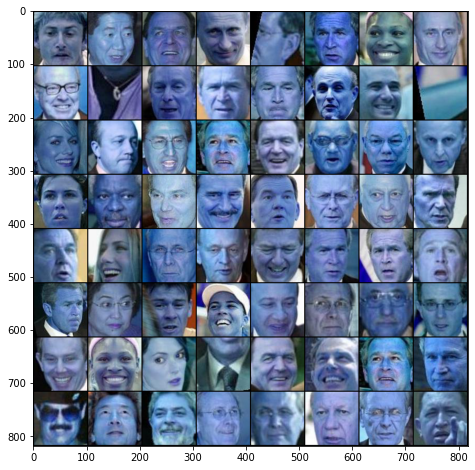

In [4]:
# Your Code Here
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = iter(train_loader).next()
# show images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images))

# 2. Define the Model

Let's use again a pretrained VGG-16 model. Create an instance of the model, e.g., called `model_1` and replace the final layer with a custom layer to output 62 class probabilities. 

In [10]:
# Your Code Here
model_1 = torchvision.models.vgg16(pretrained=True)
model_1.classifier._modules['6'] = nn.Linear(4096, 62)
model_1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Move the model to the GPU device. 

In [11]:
# Your Code Here
model_1.to("cuda")

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 3. Train and Evaluate the Model

Train the model, plot the learning curves, and evaluate the performance on the test dataset. It is expected to achieve a test accuracy of over 90%. If needed, retrain the model with different number of epochs, learning rate, or other hyperparameters that achieve over 90% accuracy. 

In [12]:
device = "cuda"
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0

    model.train() 

    for i, data in enumerate(train_loader):
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images = images.type(torch.FloatTensor)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()

    return sum_correct/total, running_loss

def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0


    model.eval()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor)
            images = images.type(torch.FloatTensor)
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            sum_correct += (predicted == labels).sum().item()
    return sum_correct/total, running_loss


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

epoch_num = 8

training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

for epoch in range(epoch_num):  

    tr_accuracy, tr_loss = train(model_1, train_loader, criterion, optimizer, epoch)

    val_accuracy, val_loss = validate(model_1, valid_loader, criterion)

    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.3f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

Epoch: 1/8	 Training loss: 172.364	 Training accuracy: 18.074	 Validation accuracy: 23.604
Epoch: 2/8	 Training loss: 129.308	 Training accuracy: 33.848	 Validation accuracy: 53.477
Epoch: 3/8	 Training loss: 80.512	 Training accuracy: 55.570	 Validation accuracy: 69.931
Epoch: 4/8	 Training loss: 44.066	 Training accuracy: 73.907	 Validation accuracy: 80.215
Epoch: 5/8	 Training loss: 28.895	 Training accuracy: 82.616	 Validation accuracy: 86.092
Epoch: 6/8	 Training loss: 18.589	 Training accuracy: 88.630	 Validation accuracy: 87.365
Epoch: 7/8	 Training loss: 13.272	 Training accuracy: 91.620	 Validation accuracy: 88.834
Epoch: 8/8	 Training loss: 8.585	 Training accuracy: 94.512	 Validation accuracy: 88.834


# 4. Train and Evaluate the Model with a Pretrained ResNet50 Model

Similarly to the VGG-16 model, import a pretrained ResNet50 model as `model_2`, and afterward train and evaluate the model on the LFW dataset. It is expected to achieve test accuracy over 90%. If needed, change the number of epochs, learning rate, or other hyperparameters.

In [18]:
# Your Code Here
model_2 = torchvision.models.resnet50(pretrained=True)
model_2.fc = nn.Linear(2048, 62)
model_2.to("cuda")

device = "cuda"
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0

    model.train() 

    for i, data in enumerate(train_loader):
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images = images.type(torch.FloatTensor)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()

    return sum_correct/total, running_loss

def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor)
            images = images.type(torch.FloatTensor)
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            sum_correct += (predicted == labels).sum().item()
    return sum_correct/total, running_loss


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

epoch_num = 6

training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

for epoch in range(epoch_num):  

    tr_accuracy, tr_loss = train(model_2, train_loader, criterion, optimizer, epoch)

    val_accuracy, val_loss = validate(model_2, valid_loader, criterion)

    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.3f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')
    

Epoch: 1/6	 Training loss: 174.567	 Training accuracy: 17.220	 Validation accuracy: 24.192
Epoch: 2/6	 Training loss: 131.466	 Training accuracy: 35.327	 Validation accuracy: 41.724
Epoch: 3/6	 Training loss: 95.826	 Training accuracy: 58.922	 Validation accuracy: 60.725
Epoch: 4/6	 Training loss: 65.755	 Training accuracy: 76.109	 Validation accuracy: 70.519
Epoch: 5/6	 Training loss: 44.014	 Training accuracy: 87.282	 Validation accuracy: 80.020
Epoch: 6/6	 Training loss: 29.571	 Training accuracy: 93.066	 Validation accuracy: 81.978


# 5. Save and Load the Model Parameters

Save the state dictionary for `model_2`. 

In [22]:
# Your Code Here
test_accuracy, test_loss = validate(model_2, test_loader, criterion)
torch.save(model_2.state_dict(), 'resnet50_weights.pth')
print(test_accuracy, test_loss)

0.8112488083889419 17.37838965654373


Load the state dictionary and evaluate the performance on the test dataset to ensure that the accuracy is the same.

In [23]:
# Your Code Here
model_3 = torchvision.models.resnet50(pretrained=True)
model_3.fc = nn.Linear(2048, 62)
model_3.to("cuda")
model_3.load_state_dict(torch.load('resnet50_weights.pth'))
test_accuracy, test_loss = validate(model_3, test_loader, criterion)
print(test_accuracy, test_loss)

0.8112488083889419 17.37838965654373
